In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from collections import Counter
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import gensim
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [4]:
df_true = pd.read_csv("../data/True.csv")
df_fake = pd.read_csv("../data/Fake.csv")
df_true["label"] = 1 # adding true label
df_fake["label"] = 0 # adding fake label
df = pd.concat([df_true, df_fake])

In [5]:
# adding a column for text length
df["text_length"] = df["text"].apply(lambda x: len(str(x).split()))

In [6]:
# ensuring the dataset is correctly formatted before processing.
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns)
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

Dataset Shape: (44898, 6)

Column Names: Index(['title', 'text', 'subject', 'date', 'label', 'text_length'], dtype='object')

Missing Values:
 title          0
text           0
subject        0
date           0
label          0
text_length    0
dtype: int64

Duplicate Rows: 209


In [7]:
# Drop duplicates if found
df = df.drop_duplicates()

In [8]:
"""
found these empty text rows in `minimum text length` graph - rectified
"""
# Display rows where text is empty
df[df["text_length"] == 0]

,title,text,subject,date,label,text_length
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",1,0
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017",0,0
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017",0,0
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",0,0
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017",0,0
...,...,...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015",0,0
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015",0,0
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015",0,0
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015",0,0


In [9]:
# removing empty text rows so that no completely blank articles are fed into the model.
df = df[df["text_length"] > 0].reset_index(drop=True)

print("new dataset shape:", df.shape)

new dataset shape: (44058, 6)


In [10]:
df.head()

,title,text,subject,date,label,text_length
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,749
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,624
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,457
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,376
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,852


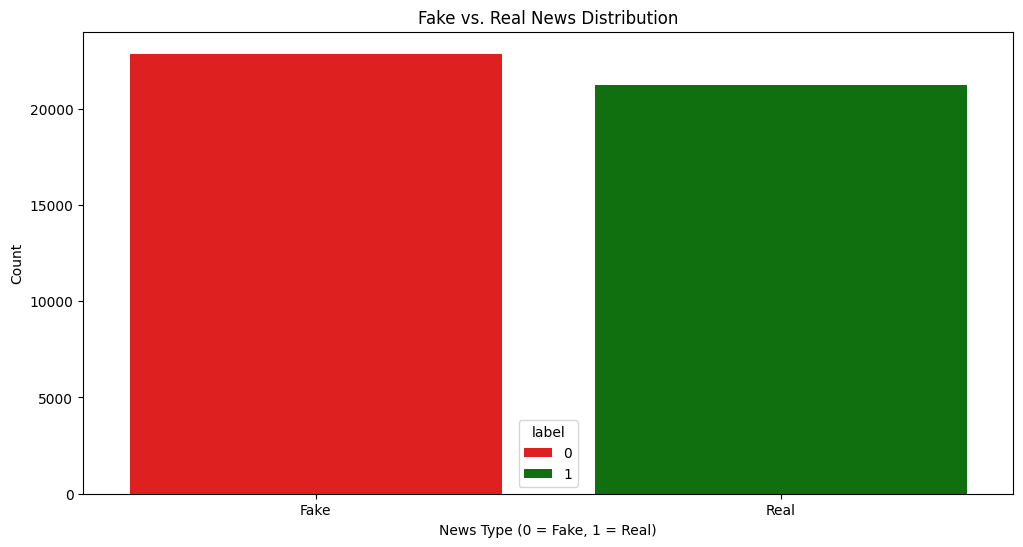

In [10]:
"""
- ensures balanced dataset for training. imbalanced datasets require oversampling or undersampling.
"""

# plot for class distribution
plt.figure(figsize=(12,6))
sns.countplot(x=df["label"], palette=["red", "green"], hue=df["label"])
plt.title("Fake vs. Real News Distribution")
plt.xlabel("News Type (0 = Fake, 1 = Real)")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=["Fake", "Real"])
plt.show()


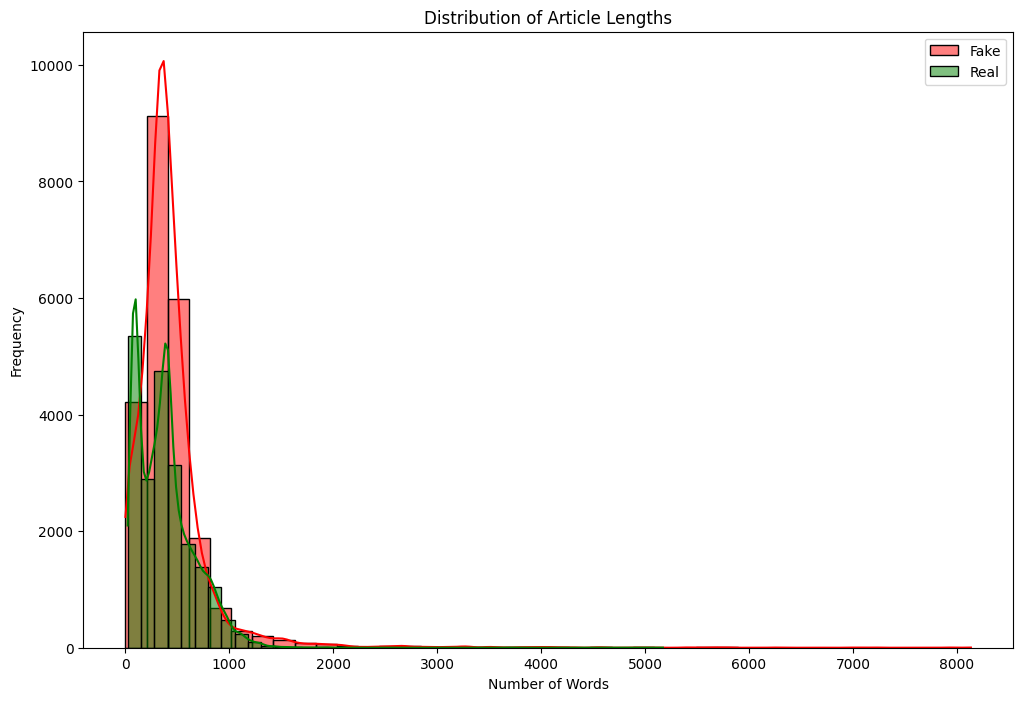

In [11]:
"""
- fake news may be shorter or longer than real news. helps with feature selection (word count as a feature).
"""

# plot for distribution of text length
plt.figure(figsize=(12,8))
sns.histplot(df[df["label"] == 0]["text_length"], bins=40, color="red", label="Fake", kde=True)
sns.histplot(df[df["label"] == 1]["text_length"], bins=40, color="green", label="Real", kde=True)
plt.legend()
plt.title("Distribution of Article Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


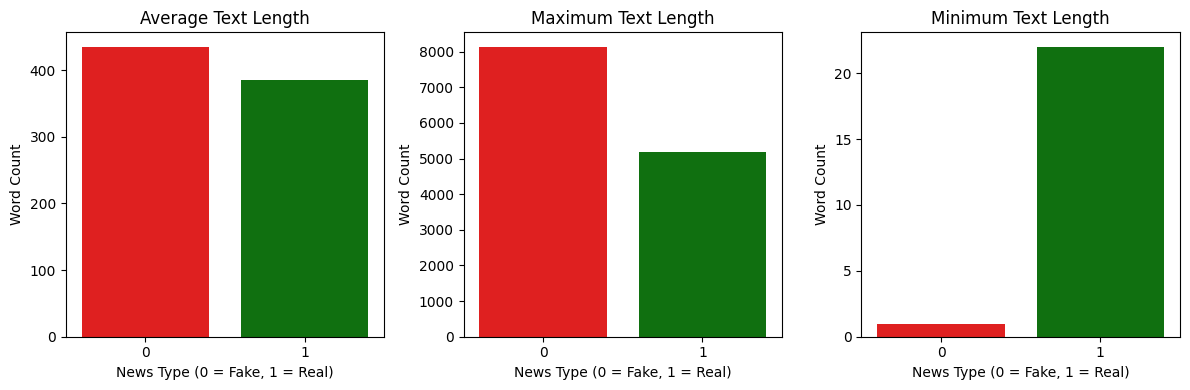

In [12]:
# compute average text length
avg_text_length = df.groupby("label")["text_length"].mean()

# compute max text length
max_text_length = df.groupby("label")["text_length"].max()

# compute min text length
min_text_length = df.groupby("label")["text_length"].min()

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# bar chart for average text length
sns.barplot(x=avg_text_length.index, y=avg_text_length.values, ax=axes[0], palette=["red", "green"], hue=avg_text_length.index, legend=False)
axes[0].set_title("Average Text Length")
axes[0].set_xlabel("News Type (0 = Fake, 1 = Real)")
axes[0].set_ylabel("Word Count")

# bar chart for max text length
sns.barplot(x=max_text_length.index, y=max_text_length.values, ax=axes[1], palette=["red", "green"], hue=max_text_length.index, legend=False)
axes[1].set_title("Maximum Text Length")
axes[1].set_xlabel("News Type (0 = Fake, 1 = Real)")
axes[1].set_ylabel("Word Count")

# bar chart for min text length
sns.barplot(x=min_text_length.index, y=min_text_length.values, ax=axes[2], palette=["red", "green"], hue=min_text_length.index, legend=False)
axes[2].set_title("Minimum Text Length")
axes[2].set_xlabel("News Type (0 = Fake, 1 = Real)")
axes[2].set_ylabel("Word Count")

plt.tight_layout()
plt.show()


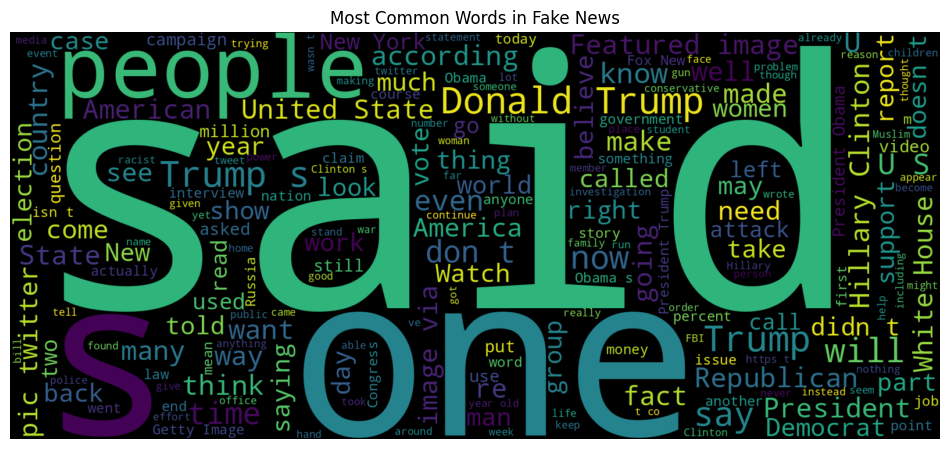

In [12]:
"""
- Identifies common words in Fake vs. Real news.
- Helps in removing irrelevant words (stopwords, unimportant words).
"""
# generate word clouds
fake_text = " ".join(df[df["label"] == 0]["text"].dropna())
real_text = " ".join(df[df["label"] == 1]["text"].dropna())

# fake news word cloud
plt.figure(figsize=(12,8))
wordcloud = WordCloud(width=1600, height=700).generate(fake_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Fake News")
plt.show()

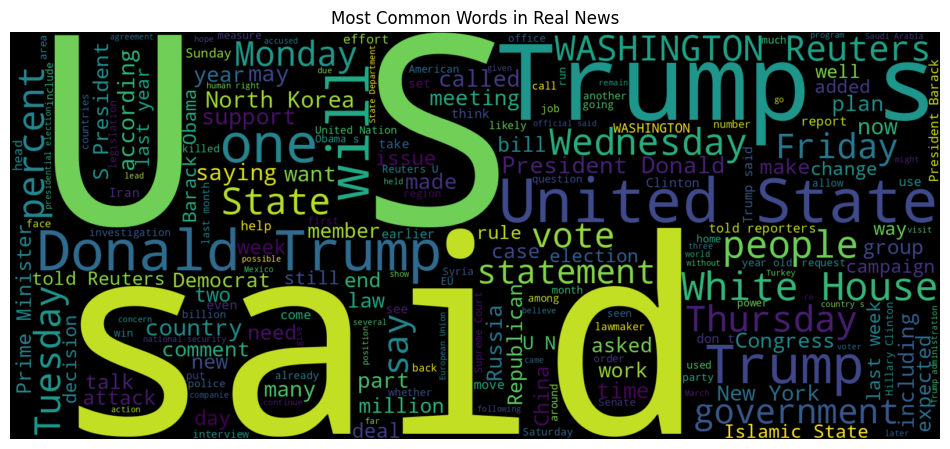

In [13]:
# real news word cloud
plt.figure(figsize=(12,8))
wordcloud = WordCloud(width=1600, height=700).generate(real_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Real News")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


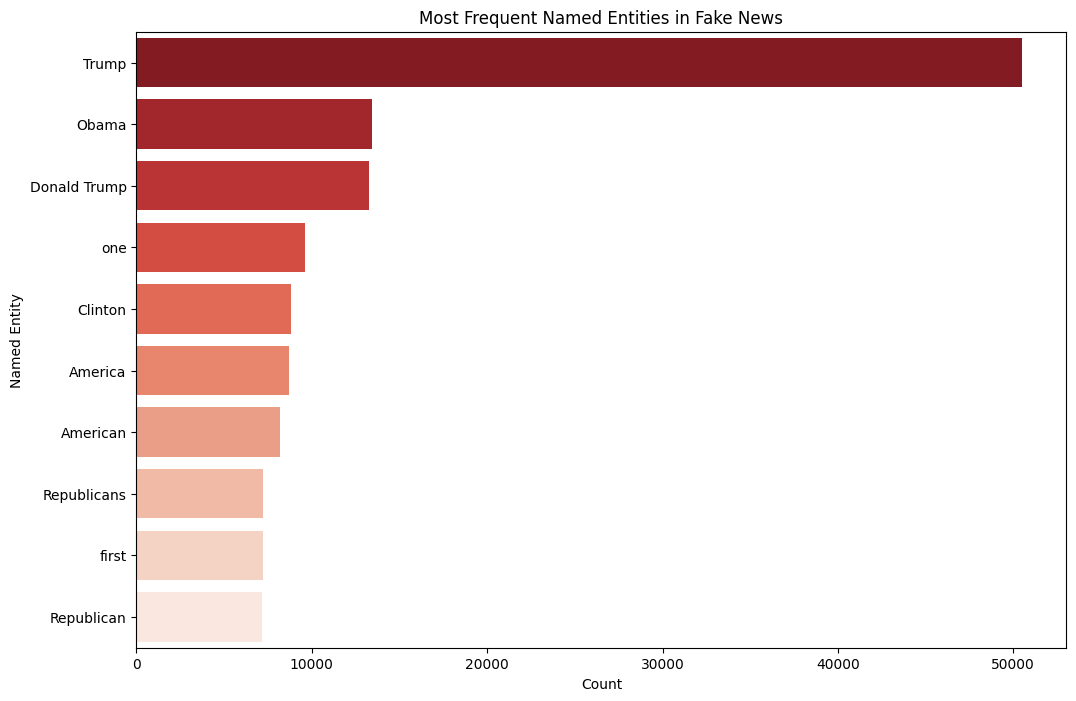

In [19]:
"""
- Finds which names, places, or organizations appear more in fake news.
- Helps understand bias in news sources. It can be used to track misinformation trends.
"""
# load spaCy's NLP model
nlp = spacy.load("en_core_web_sm")

# extract named entities from fake news
fake_entities = []
for doc in nlp.pipe(df[df["label"] == 0]["text"].dropna(), disable=["parser", "tagger"]):
    fake_entities.extend([ent.text for ent in doc.ents])

# count top entities
fake_entity_counts = Counter(fake_entities).most_common(10)

# plot most common named entities in fake news
plt.figure(figsize=(12,8))
sns.barplot(y=[i[0] for i in fake_entity_counts], x=[i[1] for i in fake_entity_counts], palette="Reds_r", hue=[i[0] for i in fake_entity_counts])
plt.title("Most Frequent Named Entities in Fake News")
plt.xlabel("Count")
plt.ylabel("Named Entity")
plt.show()

In [ ]:
"""
- Raw text cannot be fed directly into machine learning models.
- We need to clean, transform, and extract useful features from the text.
"""

In [11]:
"""
- Remove noise from text to improve model performance.
- Convert text to lowercase (standardization)
- Remove special characters, punctuation, numbers
"""

def clean_text(text):
    text = text.lower()  # convert text to lowercase
    text = re.sub(r'\W+', ' ', text)  # remove special characters from the text
    text = re.sub(r'\d+', '', text)  # remove numbers from the text
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)


In [17]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

"""
- Tokenization: Break text into smaller units (words/tokens)
- Essential for vectorization (TF-IDF, Word2Vec, BERT)
- Remove common words that don’t add meaning (e.g: “the”, “is”, “and”)
- Lemmatization: Reduce words to their root form (e.g: “running” -> “run”)
"""
df["tokens"] = df["clean_text"].apply(word_tokenize)

stop_words = set(stopwords.words("english"))
df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in stop_words])

lemmatizer = WordNetLemmatizer()
df["tokens"] = df["tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikhilreddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nikhilreddy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikhilreddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nikhilreddy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
"""
- TF-IDF (Term Frequency-Inverse Document Frequency): Weighs important words higher (e.g., "government" is more useful than "the")
- TF-IDF matrix (Rows = Articles, Columns = Words, Weighted Scores)
"""
# Convert tokens back to processed text for ML models
df["clean_text_ml"] = df["tokens"].apply(lambda x: " ".join(x))

# initializing TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text_ml"])


print("TF-IDF Matrix Shape:", X_tfidf.shape)


TF-IDF Matrix Shape: (44058, 5000)


In [19]:
"""
- 
"""
# using TF-IDF features for classical ML models
X = X_tfidf  
y = df["label"]

# spliting data into train & test (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (35246, 5000)
Testing Data Shape: (8812, 5000)


In [20]:
"""
- Train & Evaluate Multiple ML Models
- Logistic Regression, Naïve Bayes, SVM, Random Forest are common for text classification.
"""

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# initializing models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naïve Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(kernel="linear"),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# train & evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Print Accuracy & Classification Report
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")



Training Logistic Regression...
Logistic Regression Accuracy: 0.9879
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4570
           1       0.98      0.99      0.99      4242

    accuracy                           0.99      8812
   macro avg       0.99      0.99      0.99      8812
weighted avg       0.99      0.99      0.99      8812


Training Naïve Bayes...
Naïve Bayes Accuracy: 0.9307
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4570
           1       0.93      0.93      0.93      4242

    accuracy                           0.93      8812
   macro avg       0.93      0.93      0.93      8812
weighted avg       0.93      0.93      0.93      8812


Training Support Vector Machine...
Support Vector Machine Accuracy: 0.9948
Classification Report:
              precision    recall  f1-score   support

           0       1.0

In [21]:
from sklearn.model_selection import cross_val_score
"""
- Steps to check for overfitting:
- Compare training & test accuracy
- Use Cross-Validation (K-Fold CV): Ensures models generalize well across different data splits
"""

# perform 5-Fold Cross Validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    print(f"{name} - CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Logistic Regression - CV Accuracy: 0.9853 ± 0.0016
Naïve Bayes - CV Accuracy: 0.9294 ± 0.0062
Support Vector Machine - CV Accuracy: 0.9923 ± 0.0011
Random Forest - CV Accuracy: 0.9970 ± 0.0009


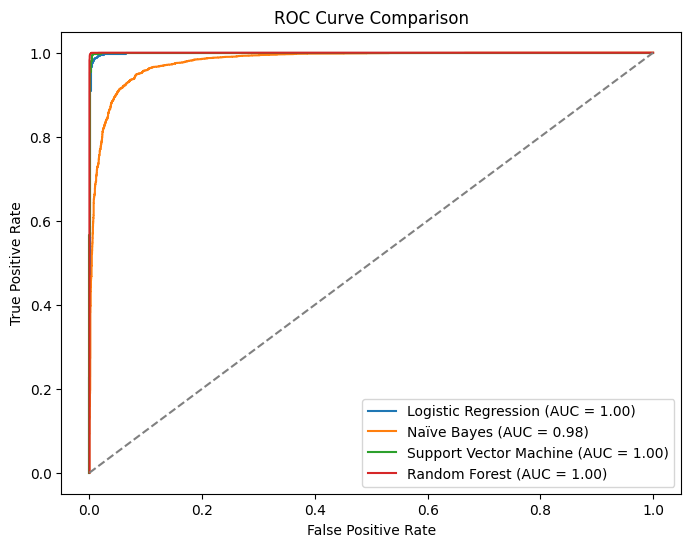

In [22]:
from sklearn.metrics import roc_curve, auc

"""
- Plot ROC Curve for All Models: Shows how well models separate Fake vs. Real news
- Helps confirm if models are overfitting (too perfect results)
"""
plt.figure(figsize=(8,6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [15]:
"""
- Convert text into tokenized sequences & ensure fixed length.
"""

# Hyperparameters
MAX_VOCAB_SIZE = 20000  # Limit vocab size to prevent memory overload
MAX_SEQUENCE_LENGTH = 200  # Fixed input size for LSTM

# Tokenization
# Split data BEFORE tokenization
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"])

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # FIT ONLY ON TRAINING DATA

# Convert train & test text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

# Verify shape
print("Train Padded Sequences Shape:", X_train_padded.shape)
print("Test Padded Sequences Shape:", X_test_padded.shape)



Train Padded Sequences Shape: (35246, 200)
Test Padded Sequences Shape: (8812, 200)


In [12]:
"""
- Load Pretrained GloVe Embeddings
- Converts words into dense numerical vectors instead of one-hot encoding.
"""
# Path to GloVe embeddings (You may need to download 'glove.6B.100d.txt')
GLOVE_PATH = "../data/glove.6B.100d.txt"

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(GLOVE_PATH, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Loaded {} word vectors.".format(len(embeddings_index)))


Loaded 400000 word vectors.


In [13]:
"""
- we map the words from our vocabulary (tokenizer.word_index) to their corresponding GloVe vectors.
- Each word in our dataset will be mapped to a dense vector.
"""

EMBEDDING_DIM = 100  # Must match the dimension of GloVe embeddings

# Create an embedding matrix where each row is a word vector
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding Matrix Shape:", embedding_matrix.shape)


Embedding Matrix Shape: (20000, 100)


In [14]:
"""
- LSTM Model
- Embedding Layer -> Uses the GloVe matrix (preloaded)
- Bidirectional LSTM -> Captures long-range dependencies
- Dropout Layer -> Prevents overfitting
- Dense Output Layer -> Predicts Fake vs. Real news
"""
# Define LSTM model
model = Sequential([
    # Embedding Layer (Pretrained GloVe embeddings)
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, 
              weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False),
    
    # LSTM Layer (Now with input shape)
    Bidirectional(LSTM(62, return_sequences=True, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))),
    Dropout(0.4),
    
    # Second LSTM Layer
    Bidirectional(LSTM(32, return_sequences=False)),  # No return_sequences for final LSTM
    Dropout(0.4),
    
    # Fully Connected Layers
   Dense(32, activation="relu", kernel_regularizer=l2(0.01)), 
    Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))  # Explicitly define input shape at model level
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Check model summary again
model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 124)       │        80,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 124)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        40,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,123,153 (8.10 MB)

 Trainable params: 123,153 (481.07 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [15]:

"""
- ReduceLROnPlateau helps adjust learning rate dynamically to avoid getting stuck.
- EarlyStopping prevents overfitting and saves time.
- Callbacks ensure automated model optimization without manual intervention.
"""

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test),
                    epochs=20, batch_size=32, callbacks=[early_stopping, reduce_lr])


Epoch 1/20
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 386s 342ms/step - accuracy: 0.9690 - loss: 0.2340 - val_accuracy: 0.9986 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 2/20
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 306s 277ms/step - accuracy: 0.9972 - loss: 0.0219 - val_accuracy: 0.9986 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 3/20
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 398s 362ms/step - accuracy: 0.9985 - loss: 0.0131 - val_accuracy: 0.9990 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 4/20
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 388s 352ms/step - accuracy: 0.9984 - loss: 0.0106 - val_accuracy: 0.9989 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 5/20
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 298s 270ms/step - accuracy: 0.9989 - loss: 0.0079 - val_accuracy: 0.9989 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 6/20
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 299s 272ms/step - accuracy: 0.9989 - loss: 0.0065 - val_accuracy: 0.9990 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 7/20
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 321s 271ms

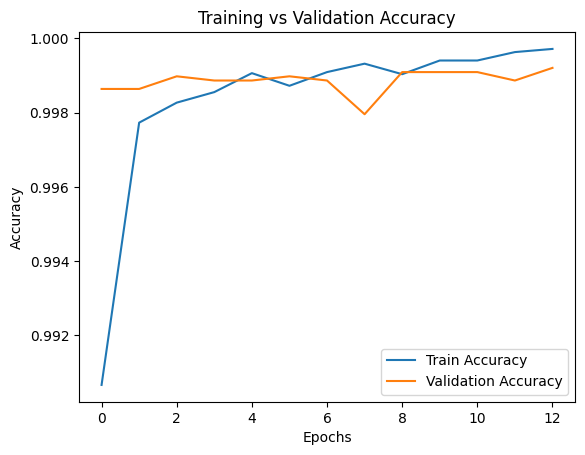

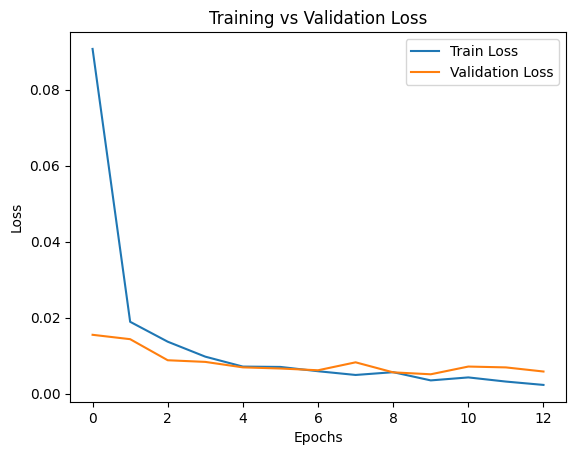

In [16]:
"""
Plot Accuracy & Loss Curves
- Confirms if validation loss & accuracy trends are stable.
"""

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [17]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.9994 - loss: 0.0040
Test Accuracy: 0.9991
Test Loss: 0.0051


In [18]:
# Get predictions on test set
y_pred = model.predict(X_test_padded)

# Convert probabilities to binary labels
y_pred = (y_pred > 0.5).astype(int)  

# Print classification report
print(classification_report(y_test, y_pred))


276/276 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4570
           1       1.00      1.00      1.00      4242

    accuracy                           1.00      8812
   macro avg       1.00      1.00      1.00      8812
weighted avg       1.00      1.00      1.00      8812



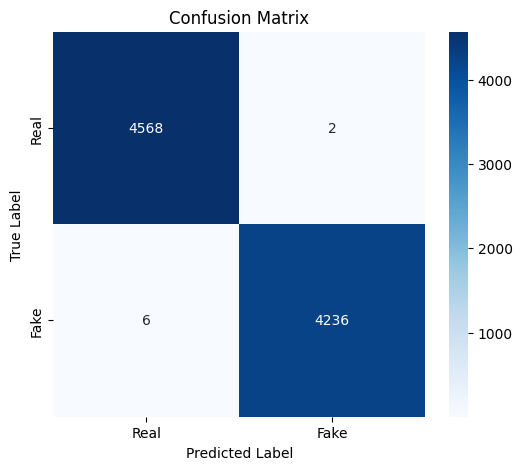

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [20]:
print(f"Training Accuracy: {max(history.history['accuracy'])}") 
print(f"Validation Accuracy: {max(history.history['val_accuracy'])}") 
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 0.9997162818908691
Validation Accuracy: 0.9992056488990784
Test Accuracy: 0.9991


In [25]:
# save model to use it for later
model.save("../models/fake_news_detector.keras")

In [22]:
# Save tokenizer
with open("../models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [4]:
# Load saved model
model = load_model("../models/fake_news_detector.keras")

# Verify it's working
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 124)       │        80,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 124)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        40,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369,461 (9.04 MB)

 Trainable params: 123,153 (481.07 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 246,308 (962.14 KB)

In [24]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions on test set
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Print classification report
print(classification_report(y_test, y_pred))


276/276 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - accuracy: 0.9994 - loss: 0.0040
Test Accuracy: 0.9991
Test Loss: 0.0051
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4570
           1       1.00      1.00      1.00      4242

    accuracy                           1.00      8812
   macro avg       1.00      1.00      1.00      8812
weighted avg       1.00      1.00      1.00      8812

